# Clustering and differential expression analysis using scVI-tools

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import json
import anndata
import scvi
import os

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset_name = 'PBMC1' # modify this
data_in_path = './data/{}/filtered/10X/'.format(dataset_name)
data_out_path = './data/{}/scvi-tools/'.format(dataset_name)
antibody_path = '{}antibody/'.format(data_out_path)
top_number_of_markers = 500

## Data loading and preparation

Dataset loading 

In [3]:
adata = sc.read_10x_mtx(
    data_in_path,
    var_names='gene_symbols',
    cache=False
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6966 × 13600
    var: 'gene_ids'

Studying feature variance

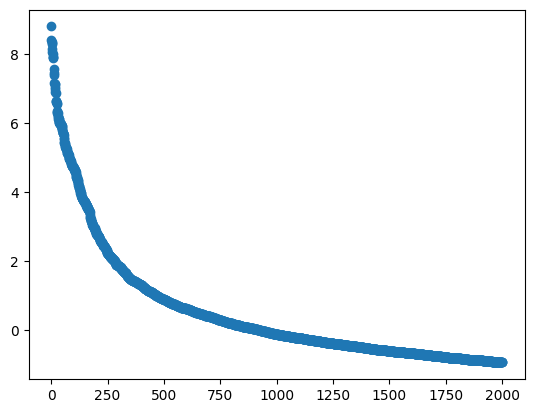

In [4]:
matrix = adata.X
matrix = matrix.todense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [5]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Feature selection

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


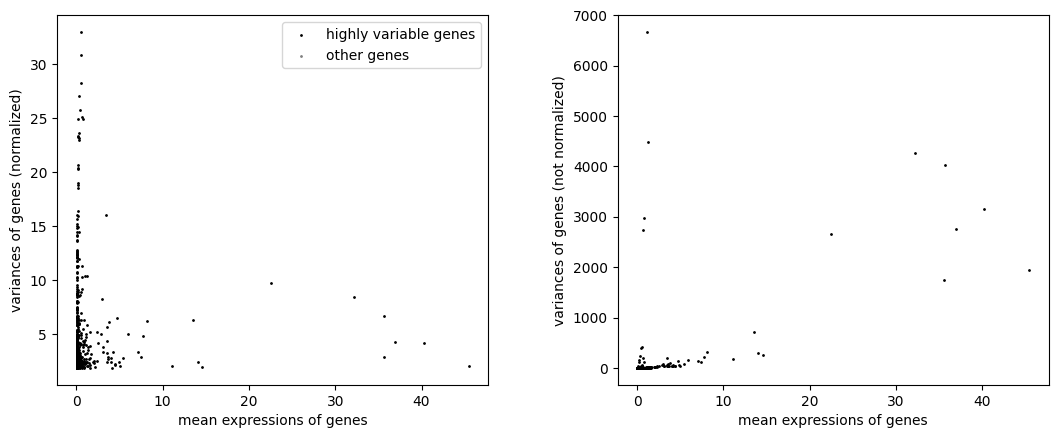

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

## Model training

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

model = scvi.model.SCVI(adata)
model.train(use_gpu=False)

I0000 00:00:1741453110.270335       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:46<00:00,  2.35it/s, v_num=1, train_loss_step=188, train_loss_epoch=190]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:46<00:00,  2.40it/s, v_num=1, train_loss_step=188, train_loss_epoch=190]


Save latent representation

In [8]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression()

Plot pca explained variance ratio to choose number of components

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


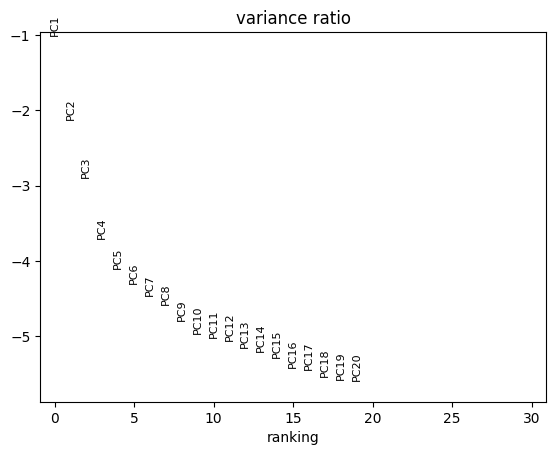

In [9]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

## Differential expression on default clusters

Perform the differential expression analysis

In [10]:
antibody_labels = pd.read_csv('./data/{}/antibody_annotation/antibody_labels_train.csv'.format(dataset_name))
antibody_labels.set_index('cell', inplace=True)
adata.obs = adata.obs.join(antibody_labels, how="left")
adata = adata[~adata.obs['cluster.ids'].isna()].copy()
adata.obs['cluster.ids'] = adata.obs['cluster.ids'].astype('category')
de_df = model.differential_expression(
    groupby="cluster.ids",
)

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


DE...: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]


Save markers

In [11]:
markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
lfc_df = pd.DataFrame(columns=['gene', 'cluster', 'lfc_mean'])
cats = adata.obs['cluster.ids'].cat.categories
for i, c in enumerate(cats):
    cell_type_df = de_df.loc[de_df.group1 == c]
    cell_type_df = cell_type_df.copy()
    cell_type_df['abs_lfc_mean'] = cell_type_df['lfc_mean'].abs()
    cell_type_df = cell_type_df.sort_values('abs_lfc_mean', ascending=False)
    cell_type_df['rank'] = rankdata(-cell_type_df['abs_lfc_mean'], method="ordinal")
    cell_type_df['cluster'] = c
    cell_type_df.reset_index(inplace=True)
    cell_type_df['gene'] = cell_type_df['index']
    markers_df = pd.concat([markers_df, cell_type_df[['gene', 'cluster', 'rank']]])
    lfc_df = pd.concat([lfc_df, cell_type_df[['gene', 'cluster', 'abs_lfc_mean']]])
markers_df['cluster'] = markers_df['cluster'].astype(str)
markers_df['rank'] = markers_df['rank'].astype(int)
markers_df.to_csv(f'{antibody_path}/markers.csv', index=False)
lfc_df['cluster'] = lfc_df['cluster'].astype(str)
lfc_df.to_csv(f'{antibody_path}/markers_abslfc.csv', index=False)

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_5705/771365139.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  markers_df = pd.concat([markers_df, cell_type_df[['gene', 'cluster', 'rank']]])
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_5705/771365139.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lfc_df = pd.concat([lfc_df, cell_type_df[['gene', 'cluster', 'abs_lfc_mean']]])
